# Pair Density ERI Analysis

Compare Electron Repulsion Integrals (ERIs) calculated with pair density with ERIs calculated by explicit sum implemented in the Rust and CUDA code. Also we analyse the momentum grid and $\psi_i(p)$ represented as a 3D array

In [1]:
import os
import xmltodict
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature_qe.eri_pair_densities import eri_gamma
from qiskit_nature_qe import calc_matrix_elements
from qiskit_nature_qe.wfc import Wfc

Load data

In [2]:
hdf5_file = os.path.join("qe_files", "out_H2", "H2.save", "wfc1.hdf5")
dat_file = os.path.join("qe_files", "out_H2", "H2.save", "wfc1.dat")
xml_file = os.path.join("qe_files", "out_H2", "H2.save", "data-file-schema.xml")

# Choose Kohn-Sham orbitals
orbitals_indices = [0, 1]

wfc1_ncpp = Wfc.from_file(hdf5_file, xml_file)

with open(xml_file, "r", encoding="utf-8") as file:
    xml_dict = xmltodict.parse(file.read())
reference_energy = xml_dict["qes:espresso"]["output"]["total_energy"]["etot"]

overlaps_ncpp = wfc1_ncpp.get_overlaps()

p = wfc1_ncpp.k_plus_G  # shape (#waves, 3)
c_ip = wfc1_ncpp.evc  # shape (#bands, #waves)

Calculate ERIs via pair densities

In [3]:
# For application we need to rescale ERIs by the cell volume
# Commented out for comparing with Rust and CUDA results
eri = eri_gamma(p=p, c_ip_up=c_ip)  # / wfc1_ncpp.cell_volume

Check symmetries of calculated ERIs

In [4]:
# Check symmetries of ERIs
sym = calc_matrix_elements.check_symmetry_two_body_matrix(eri)
print(
    f"swap symmetry {'fulfilled' if sym[0] else 'not fulfilled'}, "
    f"hermiticity {'fulfilled' if sym[1] else 'not fulfilled'}, hermiticity+swap {'fulfilled' if sym[2] else 'not fulfilled'}!"
)

swap symmetry fulfilled, hermiticity fulfilled, hermiticity+swap fulfilled!


Plot momentum grid used in QuantumEspresso projected on the x-y-plane

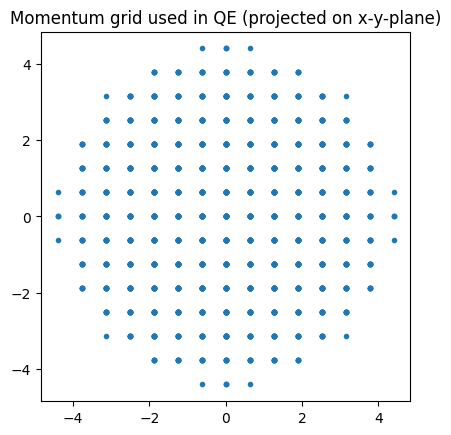

In [5]:
# Plot momentum grid used in QuantumEspresso (projected on x-y-plane)
plt.figure()
plt.title("Momentum grid used in QE (projected on x-y-plane)")
plt.plot(p[:, 0], p[:, 1], ".")
plt.gca().set_aspect("equal")

Create 3D array of $\psi_i(p)$ as done in `eri_gamma` function. Also compute shifted $\psi_i(p)$ used as input for numpy FFT methods

In [6]:
# Create 3d array containing momentum vectors on a grid extend to a rectangular grid
# Same as in eri_gamma function
grid_min_x = p[:, 0].min()
grid_max_x = p[:, 0].max()
grid_min_y = p[:, 1].min()
grid_max_y = p[:, 1].max()
grid_min_z = p[:, 2].min()
grid_max_z = p[:, 2].max()
# assume equally spaced grid
grid_spacing = np.linalg.norm(p[0] - p[1], ord=2)

c_ip_array = np.zeros(
    (
        c_ip.shape[0],
        int((grid_max_x - grid_min_x) / grid_spacing) + 1,
        int((grid_max_y - grid_min_y) / grid_spacing) + 1,
        int((grid_max_z - grid_min_z) / grid_spacing) + 1,
    ),
    dtype=c_ip.dtype,
)
for idx, coords in enumerate(p):
    x, y, z = coords
    i, j, k = (
        int((x - grid_min_x) / grid_spacing),
        int((y - grid_min_y) / grid_spacing),
        int((z - grid_min_z) / grid_spacing),
    )
    c_ip_array[:, i, j, k] = c_ip[:, idx]

p_norm_array = np.zeros(c_ip_array.shape[1:])
for i in range(p_norm_array.shape[0]):
    x = (i * grid_spacing) + grid_min_x
    for j in range(p_norm_array.shape[1]):
        y = (j * grid_spacing) + grid_min_y
        for k in range(p_norm_array.shape[2]):
            z = (k * grid_spacing) + grid_min_z
            p_norm_array[i, j, k] = x**2 + y**2 + z**2

c_ip_array_shifted = np.fft.ifftshift(c_ip_array, axes=(1, 2, 3))

Plot norm of momenta, unshifted and shifted $\psi_i(p)$

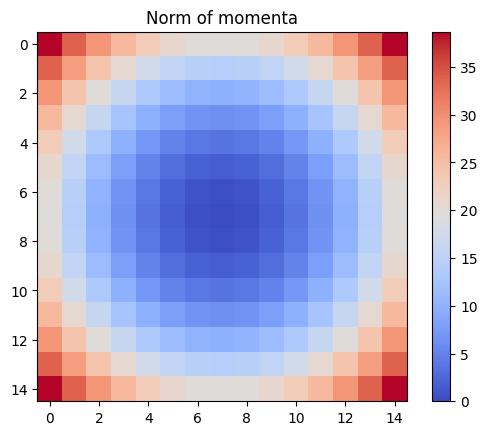

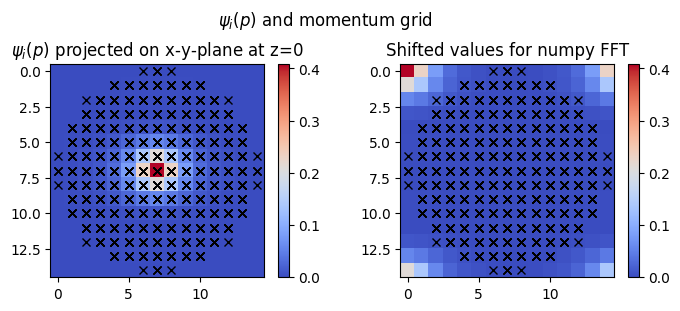

In [7]:
plt.figure()
plt.title("Norm of momenta")
plt.imshow(p_norm_array[:, :, 7], cmap="coolwarm")
plt.colorbar()

fig, ax = plt.subplots(ncols=2, figsize=(7, 3), layout="constrained")
fig.suptitle("$\psi_i(p)$ and momentum grid")
ax[0].set_title("$\psi_i(p)$ projected on x-y-plane at z=0")
im = ax[0].imshow(
    np.abs(c_ip_array[0, :, :, 7]), cmap="coolwarm"
)  # 7 is center of array of length 15
ax[0].plot(
    (p[:, 0] - grid_min_x) / grid_spacing,
    (p[:, 1] - grid_min_x) / grid_spacing,
    "x",
    c="black",
)
ax[1].set_title("Shifted values for numpy FFT")
im2 = ax[1].imshow(
    np.abs(c_ip_array_shifted[0, :, :, 0]), cmap="coolwarm"
)  # After shift center frequency is at index 0
ax[1].plot(
    (p[:, 0] - grid_min_x) / grid_spacing,
    (p[:, 1] - grid_min_x) / grid_spacing,
    "x",
    c="black",
)
fig.colorbar(im)
fig.colorbar(im2)
